In [1]:
%pip install pandas matplotlib seaborn plotly scikit-learn seaborn missingno

     ---------------------------------------- 11.6/11.6 MB 3.8 MB/s eta 0:00:00
  Using cached matplotlib-3.8.2-cp311-cp311-win_amd64.whl (7.6 MB)
     -------------------------------------- 294.9/294.9 kB 3.0 MB/s eta 0:00:00
  Using cached plotly-5.18.0-py3-none-any.whl (15.6 MB)
     ---------------------------------------- 10.6/10.6 MB 3.3 MB/s eta 0:00:00
  Using cached numpy-1.26.3-cp311-cp311-win_amd64.whl (15.8 MB)
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)
  Using cached tzdata-2023.4-py2.py3-none-any.whl (346 kB)
  Using cached contourpy-1.2.0-cp311-cp311-win_amd64.whl (187 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.47.2-cp311-cp311-win_amd64.whl (2.2 MB)
  Using cached kiwisolver-1.4.5-cp311-cp311-win_amd64.whl (56 kB)
  Using cached pillow-10.2.0-cp311-cp311-win_amd64.whl (2.6 MB)
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
  Using cached tenacity-8.2.3-py3-none-any.whl (24 kB)
     ----------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display, HTML
import missingno as mn
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set()

C:\Users\etsn\AppData\Local\Temp\ipykernel_5956\1862346140.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [64]:
#Интерактивные графики в отдельном окне
%matplotlib tk

In [65]:
%matplotlib inline

In [2]:
RANDOM_SEED = 42


Загрузка данных

In [3]:
df = pd.read_csv("autos.csv")

### Проверим типы данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Проверим  дубликаты

In [5]:
if df.duplicated().sum():
    df = df.drop_duplicates()
    df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(9)
me

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


* Преобразование данных

Начнем с даты.

In [7]:
df["DateCrawled"] = pd.to_datetime(df.DateCrawled)
df["DateCreated"] = pd.to_datetime(df.DateCreated)
df["LastSeen"] = pd.to_datetime(df.LastSeen)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64        

In [8]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354365,2016-03-21 12:58:09.520460544,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354365.0,4416.67983,0.0,1050.0,2700.0,6400.0,20000.0,4514.176349
RegistrationYear,354365.0,2004.234481,1000.0,1999.0,2003.0,2008.0,9999.0,90.228466
Power,354365.0,110.093816,0.0,69.0,105.0,143.0,20000.0,189.85133
Kilometer,354365.0,128211.363989,5000.0,125000.0,150000.0,150000.0,150000.0,37905.083858
RegistrationMonth,354365.0,5.71465,0.0,3.0,6.0,9.0,12.0,3.726432
DateCreated,354365,2016-03-20 19:12:06.583042560,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354365.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354365.0,50508.5038,1067.0,30165.0,49413.0,71083.0,99998.0,25783.100078
LastSeen,354365,2016-03-29 23:51:06.766184960,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:52,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


Видим, что есть 
* нулевая Price
* нереальный RegistrationYear
* огромная Power

Отфильтруем эти данные

<Axes: xlabel='Power', ylabel='Count'>

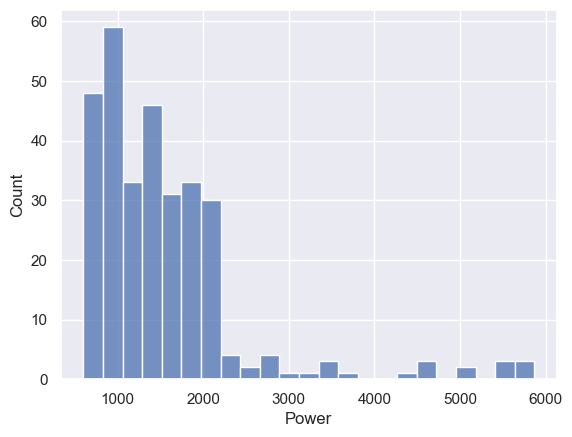

In [31]:
sns.histplot(df.Power.loc[(df.Power > 600) & (df.Power < 6000)])

Возможно пользователь ошибся и добавил лишние нули. Попробуем восстановить мощность по модели

Найдем среднее значение мощности для выбранных моделей

In [9]:
huge_power_models = df.loc[df.Power > 600].Model.unique().tolist()
median_power = {}
for model in huge_power_models:
    median = df["Power"].loc[df.Model == model].median()
    try:
        median_power[model] = round(median)
    except ValueError:
        print(model, "can't convert to int", median)


nan can't convert to int nan


In [10]:
# Удалим other
del median_power["other"]

In [11]:
# сохраним датасет
original_df = df.copy()


In [12]:
df = original_df.copy()

In [13]:
original_df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354365,2016-03-21 12:58:09.520460544,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354365.0,4416.67983,0.0,1050.0,2700.0,6400.0,20000.0,4514.176349
RegistrationYear,354365.0,2004.234481,1000.0,1999.0,2003.0,2008.0,9999.0,90.228466
Power,354365.0,110.093816,0.0,69.0,105.0,143.0,20000.0,189.85133
Kilometer,354365.0,128211.363989,5000.0,125000.0,150000.0,150000.0,150000.0,37905.083858
RegistrationMonth,354365.0,5.71465,0.0,3.0,6.0,9.0,12.0,3.726432
DateCreated,354365,2016-03-20 19:12:06.583042560,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354365.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354365.0,50508.5038,1067.0,30165.0,49413.0,71083.0,99998.0,25783.100078
LastSeen,354365,2016-03-29 23:51:06.766184960,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:52,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


In [14]:
# Восстановим мощности
df["Power"].update(df.loc[df.Power > 600]["Model"].map(median_power))


In [15]:
df.loc[df.Power > 600]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3746,2016-03-21 14:48:31,0,NaN,2017,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59
7720,2016-04-02 11:48:54,1500,small,2000,manual,1400,NaN,150000,0,petrol,honda,NaN,2016-04-02,0,21509,2016-04-04 09:15:26
11039,2016-03-25 19:55:32,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no,2016-03-25,0,57520,2016-04-01 19:16:33
21609,2016-03-29 17:53:17,200,small,2000,manual,1200,NaN,125000,4,petrol,lancia,NaN,2016-03-29,0,10585,2016-04-06 03:45:24
23173,2016-03-19 22:51:21,400,NaN,2015,auto,610,other,5000,1,NaN,audi,NaN,2016-03-19,0,70178,2016-03-20 02:42:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319576,2016-03-17 20:56:34,2300,sedan,1992,NaN,1922,NaN,150000,4,petrol,bmw,no,2016-03-17,0,45896,2016-03-17 21:43:16
320442,2016-03-22 08:54:07,3400,small,2007,NaN,732,NaN,125000,12,petrol,citroen,no,2016-03-22,0,3159,2016-04-05 21:15:48
321246,2016-03-22 18:31:32,650,suv,1996,manual,2389,NaN,150000,11,petrol,nissan,no,2016-03-22,0,35579,2016-03-29 01:16:32
348830,2016-03-22 00:38:15,1,NaN,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21,0,41472,2016-04-05 14:18:01


Для этих авто не указаны ни корректная мощность, ни модель. Удаляем их

In [16]:
df.drop(df[df.Power > 600].index, inplace=True)

In [17]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354292,2016-03-21 12:57:41.131425792,2016-03-05 14:06:22,2016-03-13 11:52:25.249999872,2016-03-21 17:50:53.500000,2016-03-29 14:37:19,2016-04-07 14:36:58,NaN
Price,354292.0,4416.97388,0.0,1050.0,2700.0,6400.0,20000.0,4514.292098
RegistrationYear,354292.0,2004.239009,1000.0,1999.0,2003.0,2008.0,9999.0,90.220542
Power,354292.0,106.476429,0.0,69.0,105.0,141.0,600.0,63.446824
Kilometer,354292.0,128215.821977,5000.0,125000.0,150000.0,150000.0,150000.0,37899.204992
RegistrationMonth,354292.0,5.714718,0.0,3.0,6.0,9.0,12.0,3.726337
DateCreated,354292,2016-03-20 19:11:37.174082304,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354292.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354292.0,50508.523918,1067.0,30165.0,49406.0,71083.0,99998.0,25783.131646
LastSeen,354292,2016-03-29 23:51:09.803822848,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:54.500000,2016-04-06 10:15:20,2016-04-07 14:58:51,NaN


Отфильтруем RegistrationDate

In [18]:
df.RegistrationYear.loc[df.RegistrationYear > 2019].describe().T # Перебором года удалось выяснить граничный реальный год

count     105.000000
mean     6399.276190
std      2750.727549
min      2066.000000
25%      4100.000000
50%      5911.000000
75%      9996.000000
max      9999.000000
Name: RegistrationYear, dtype: float64

<Axes: >

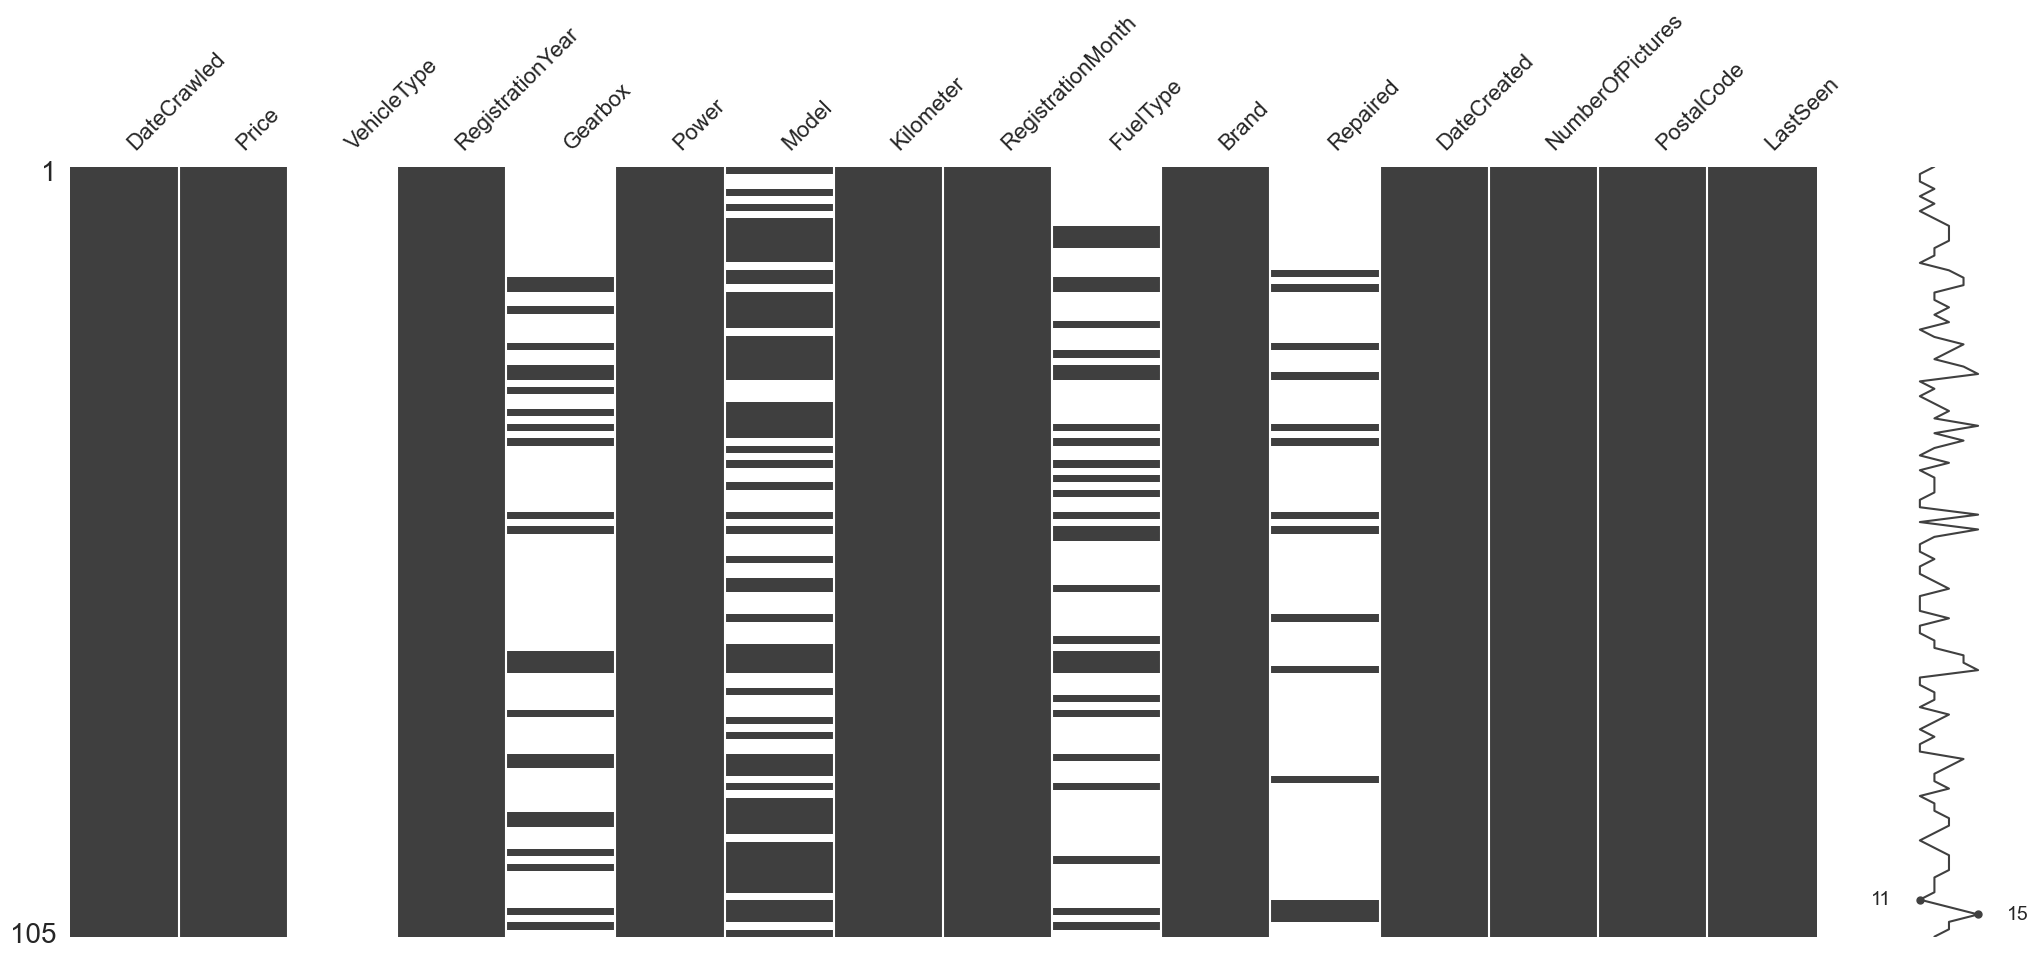

In [41]:
mn.missingno.matrix(df.loc[df.RegistrationYear > 2019])

Как видно, пользователи не удосужился заполнить объявление. Т.к. таких объявлений не много, то мы их безжалостно выбросим

In [19]:
df.drop(df.loc[df.RegistrationYear > 2019].index, inplace=True)
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354187,2016-03-21 12:57:23.743542016,2016-03-05 14:06:22,2016-03-13 11:52:13.500000,2016-03-21 17:50:51,2016-03-29 14:37:17,2016-04-07 14:36:58,NaN
Price,354187.0,4417.414403,0.0,1050.0,2700.0,6400.0,20000.0,4514.185231
RegistrationYear,354187.0,2002.936085,1000.0,1999.0,2003.0,2008.0,2019.0,13.866662
Power,354187.0,106.496819,0.0,69.0,105.0,141.0,600.0,63.42571
Kilometer,354187.0,128250.86748,5000.0,125000.0,150000.0,150000.0,150000.0,37849.041257
RegistrationMonth,354187.0,5.716006,0.0,3.0,6.0,9.0,12.0,3.725769
DateCreated,354187,2016-03-20 19:11:17.896139520,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354187.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354187.0,50510.818703,1067.0,30165.0,49413.0,71083.0,99998.0,25783.82305
LastSeen,354187,2016-03-29 23:50:56.228977920,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:52,2016-04-06 10:15:20,2016-04-07 14:58:51,NaN


In [20]:
categorical_cols = ["VehicleType", "Gearbox", "FuelType", "Brand", "Model", "Repaired"]

 Изменим тип на категории и проверим количество пустых

In [21]:
for category in categorical_cols:
    df[category] = df[category].astype("category")


Проверим входные данные на соответствие нормальным

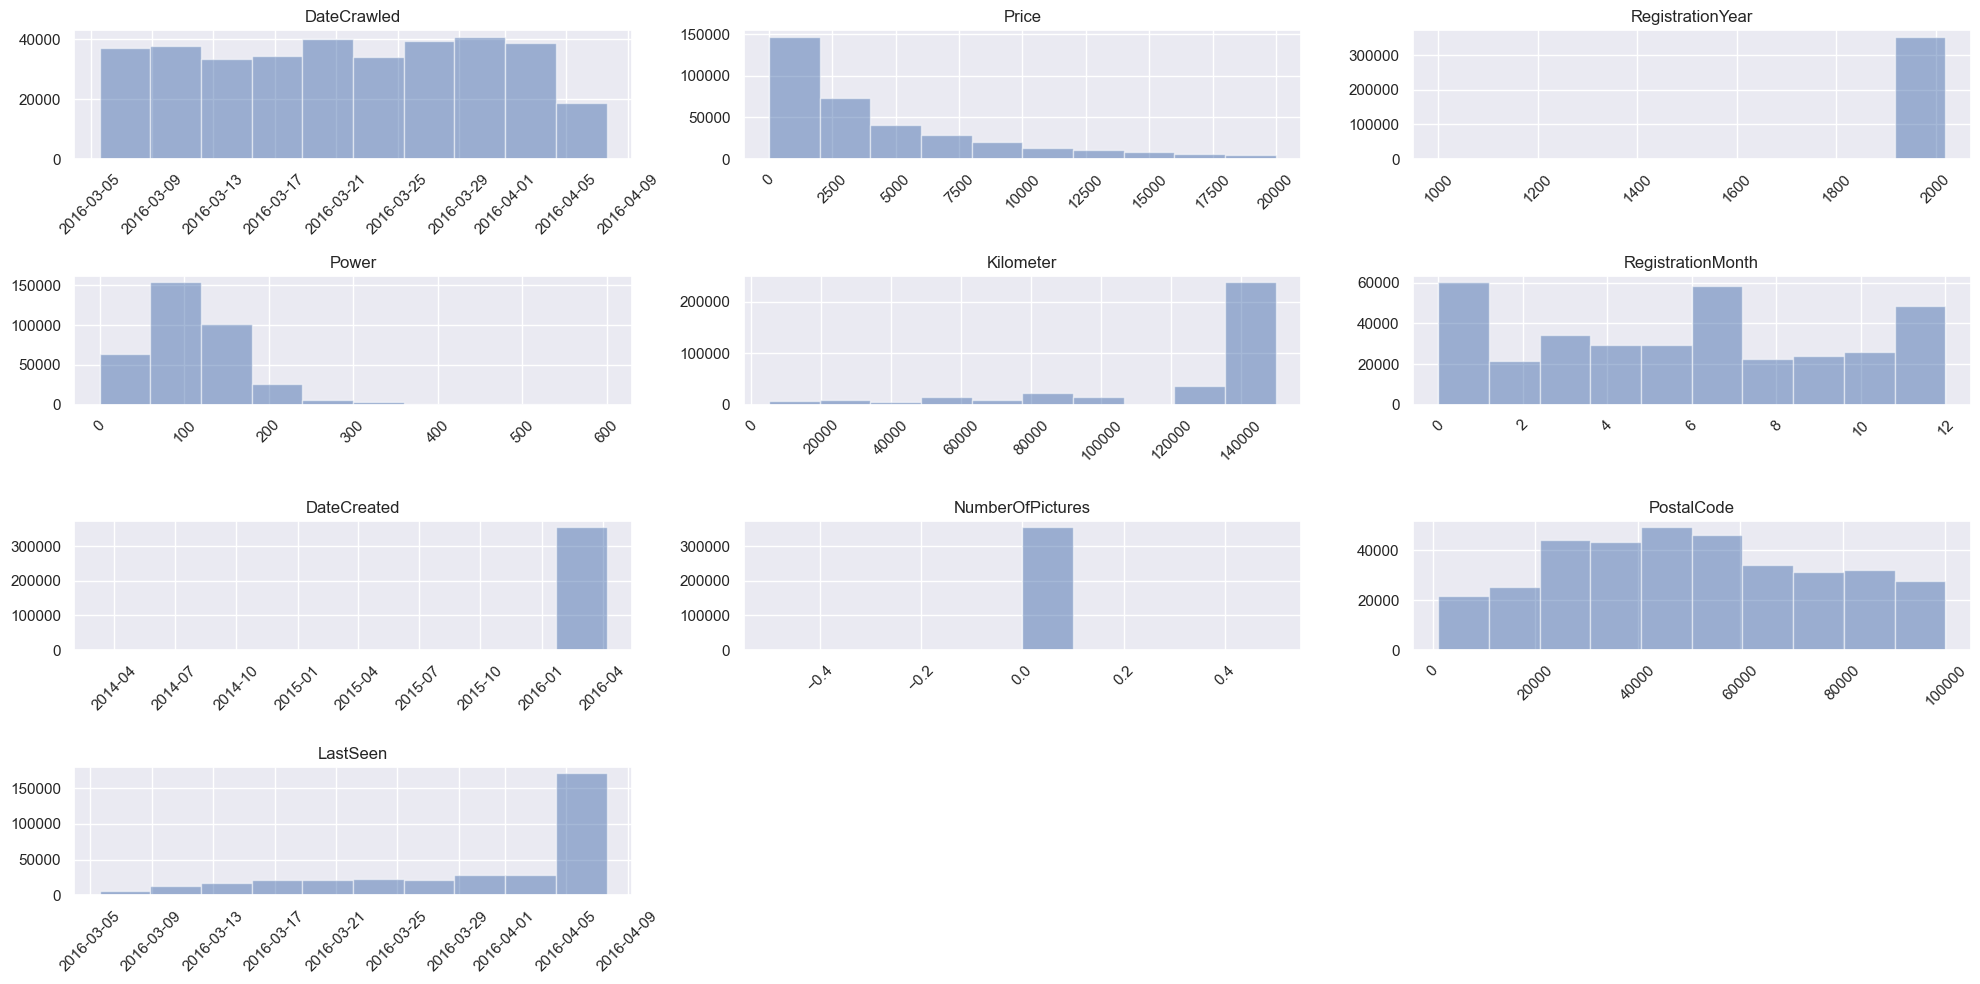

In [22]:
df.hist(alpha=0.5, figsize=(20, 10), xrot=45)
plt.tight_layout()
plt.show()


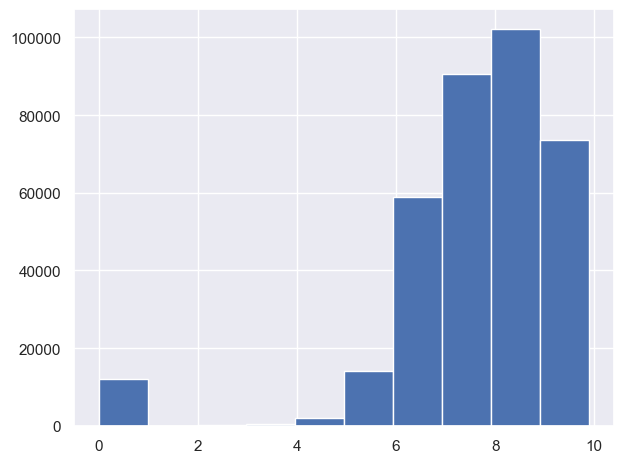

In [46]:
df["price_log"] = np.log1p(df["Price"])
df.price_log.hist()
plt.tight_layout()
plt.show()


Получилось не очень круто. Но, что имеем, то имеем.


In [ ]:
df = df.drop(columns=["price_log"]) 

Отбросим строки с незаполненной ценой

In [23]:
df = df.loc[df.Price != 0]

Изменим тип дат на int64


In [24]:
df["DateCrawled"] = df["DateCrawled"].astype("int64")
df["DateCreated"] = df["DateCreated"].astype("int64")
df["LastSeen"] = df["LastSeen"].astype("int64")
df["RegistrationYear"] = df["RegistrationYear"].astype("int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343441 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   DateCrawled        343441 non-null  int64   
 1   Price              343441 non-null  int64   
 2   VehicleType        309792 non-null  category
 3   RegistrationYear   343441 non-null  int64   
 4   Gearbox            326161 non-null  category
 5   Power              343441 non-null  int64   
 6   Model              325993 non-null  category
 7   Kilometer          343441 non-null  int64   
 8   RegistrationMonth  343441 non-null  int64   
 9   FuelType           314061 non-null  category
 10  Brand              343441 non-null  category
 11  Repaired           277669 non-null  category
 12  DateCreated        343441 non-null  int64   
 13  NumberOfPictures   343441 non-null  int64   
 14  PostalCode         343441 non-null  int64   
 15  LastSeen           343441 non-null  int

Преобразуем категории в числовые значение

In [25]:
def category_to_dict(col: pd.Series):
    map_ = {}
    for count, category in enumerate(col.unique()):
        if pd.isna(np.array([category,])):
            continue
        map_[category] = count

    return map_

In [26]:
categories_map = {}

In [27]:

for category in categorical_cols:
    map_ = category_to_dict(df[category])
    categories_map[category] = map_
    df[category] = df[category].map(map_)

In [14]:
#df.dropna(how="any", inplace=True)

<Axes: >

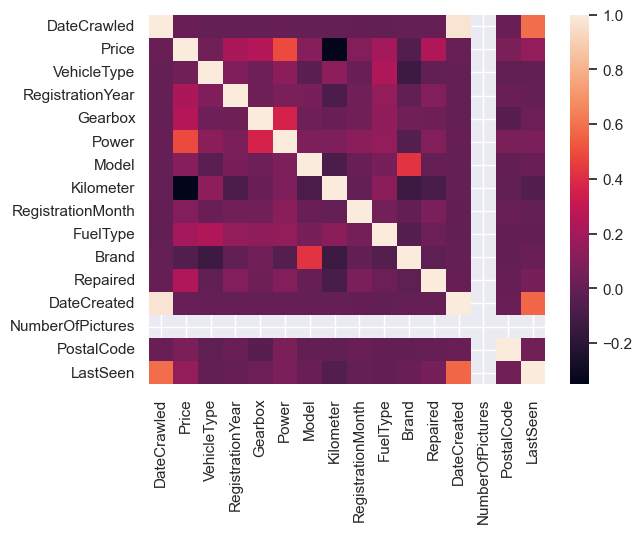

In [53]:
sns.heatmap(df.corr())

Видно, что DateCreated - DateCrawled идут нога в ногу. С ними рядом идет Last Seen. Оставим только DateCrawled
PS Позже выяснилось, что LastSeen важнее

In [28]:
df.drop(columns=["DateCreated", "DateCrawled", "NumberOfPictures"], inplace=True)

FuelType имеет слишком много значений. Проанализируем этот признак.

In [30]:
categories_map["FuelType"]

{'petrol': 0,
 'gasoline': 1,
 'lpg': 3,
 'other': 4,
 'hybrid': 5,
 'cng': 6,
 'electric': 7}

Объедением petrol и gasoline, т.к. это одно и то же

In [31]:
df.FuelType = df.FuelType.replace(to_replace=1, value=0)

Поработаем с отсутствующими данными

In [32]:
df.isna().sum()

Price                    0
VehicleType          33649
RegistrationYear         0
Gearbox              17280
Power                    0
Model                17448
Kilometer                0
RegistrationMonth        0
FuelType             29380
Brand                    0
Repaired             65772
PostalCode               0
LastSeen                 0
dtype: int64

Пойдем вабанк.
VehicleType имеет заметельную категорю - other. Поставим ее вместо nan
FuelType - пусть будет 0 (Petrol)
Repaired - очень важный признак. Неизвестное состояние пусть примет значение 3
Model меняем на other
GearBox - сложный вопрос...

Если будет необходимость, то их заменим на соответствующие из других объявлений

PS Не будем менять Repaired, т.к. это значительно снижает зависимость от этого признака


In [33]:

df['VehicleType'] = df['VehicleType'].fillna(categories_map["VehicleType"]["other"])
df['FuelType'] = df['FuelType'].fillna(categories_map["FuelType"]["petrol"])
# df['Repaired'] = df['Repaired'].cat.add_categories([3]).fillna(3)
df['Model'] = df['Model'].fillna(categories_map["Model"]["other"])
df['Gearbox'] = df['Gearbox'].cat.add_categories([3]).fillna(3)

In [34]:
df.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             65772
PostalCode               0
LastSeen                 0
dtype: int64

### 3.4 Рассмотрим признаки на основе оценки их значимости для составления математической модели:
    (Чем выше число, тем сильнее связь между признаком и целевой переменной)

In [36]:
X = df.drop('Price', axis=1)
y = df['Price']

num_features_to_select = 3
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
selector.fit(X, y)

all_feature_scores = selector.scores_
feature_names = X.columns
for feature, score in zip(feature_names, all_feature_scores):
    print(f"Признак: {feature}, Оценка: {score}")

Признак: VehicleType, Оценка: 1.7788952563258171
Признак: RegistrationYear, Оценка: 6.644675692956067
Признак: Gearbox, Оценка: 3.566833010235216
Признак: Power, Оценка: 34.396327661533114
Признак: Model, Оценка: 2.6327023989011265
Признак: Kilometer, Оценка: 16.48053609795587
Признак: RegistrationMonth, Оценка: 3.780829728574247
Признак: FuelType, Оценка: 1.0274962398086667
Признак: Brand, Оценка: 1.87637389886185
Признак: Repaired, Оценка: 7.1367536344080325
Признак: PostalCode, Оценка: 1.8489861637026863
Признак: LastSeen, Оценка: 3.5343097825373686


Разбивка на выборки и разбивка подготовка гиперпараметров (Поиск проводился многократно с использованием кросвалидации и различных моделей. Выбраны наилучшие результаты)

In [38]:
y = df["Price"]
X = df.drop(columns=["Price"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=13)

params = {'n_estimators': 500,#00,
          'max_depth': 8,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'}

Через cross vlaidation


In [41]:
X_cv = pd.concat([X_train, X_valid])
y_cv = pd.concat([y_train, y_valid])

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [8],
    'n_estimators': [550]
}

rf = ensemble.GradientBoostingRegressor(loss='squared_error')
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 10)
grid_search.fit(X_cv, y_cv)

import pickle
with open("gridscv2567000", "wb") as f:
    pickle.dump(grid_search, f)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [43]:

grid_search.best_params_

{'max_depth': 8, 'n_estimators': 550}

In [44]:
root_mean_squared_error(y_test, grid_search.predict(X_test))

1558.8307680010387

In [64]:
diff = np.subtract(np.array(y_test), grid_search.predict(X_test))

In [65]:
diff_sort = np.sort(diff)

<Axes: ylabel='Count'>

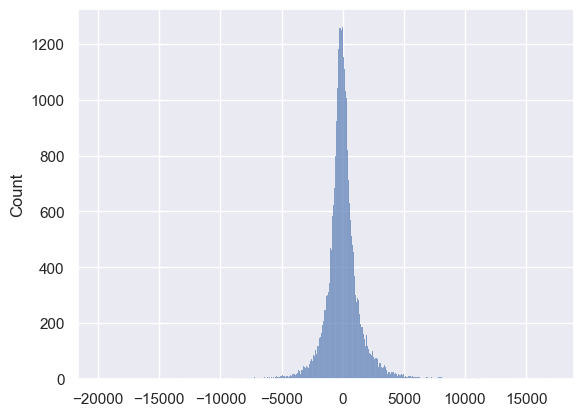

In [66]:
sns.histplot(diff_sort)